## Audio Signal Processing for Music Applications.
### Exam, December 2020
### Emma Fraxanet Morales

**Part 1**

*SOUND: u188703. http://www.freesound.org/people/NoiseCollector/sounds/113310/*

Download from freesound.org the sound assigned to you and read all the information describing it. If the sound is too long,
select a representative fragment of less than five seconds in length (2 seconds would be ideal). If the
sound does not have the recommended format change it, using any sound editor. You can also perform
some pre-processing, using any sound editor, to create a more adequate sound. Save the edited sound in
your working directory.


Create the python notebook to be used for the whole exam. Read the sound and display it. Compute its
STFT and show the magnitude spectrogram. Explain why you choose this sound fragment. Describe the
sound by using its temporal and spectral representation, focusing on what should be useful for processing
the sound with spectral models, thus for deciding the spectral analysis parameters. Show any partial,
temporal or spectral, representation of the sound to support your description.


**EXPLANATION FOR PART 1**

This sound already had the adequate characteristics so I didn't need to manipulate it or make it shorter. 
The sound is a baby babbling. Because that resembled speech I decided that a good fit would be a 'hamming' window. 
The other parameters I chose were based on this choice and the fact that the lowest hamonic (and the intervals between the first harmonics) was around 160 Hz. ( Then M = 4 (hamming) * 44100 (fs) / 160 (f0) = 1102 ). The size for the FFT is the next power of two, in this case N=2048. For the Hop size, because it is a Hamming window it had to be around the 25%. 
Then, other parameters we would use for spectral analysis are: number of sinusoidals is around 20, the frequency deviation offset is quite big ( around 50 Hz, in order to track the sines properly).

Finally as we can say in the magnitude spectogram, obtained around t=0.3, the magnitude threshold to do the detection would be fine at around -80 dB. 

All this parameters have also been tested through the model interface provided in the subject. However, there is no need to perform such sinusoidal analysis given that the second part is based on the essentia descriptors. 

In [1]:
# Import libraries
import os
import sys
import numpy as np

from scipy.signal import get_window
from scipy.fftpack import fft, fftshift

import math as m

import matplotlib.pyplot as plt
import IPython.display as ipd

sys.path.append('../software/models/')
import stft
import dftModel as DFT
import utilFunctions as UF


#Setting the parameters for this sound (explanation at the end of part 1)
H = 602
M=1102
N=2048
minSineDur = 0.05      
maxnSines = 20
freqDevOffset = 50
freqDevSlope = 0.001
window = 'hamming'
t = -80
input_file = '../sounds/113310__noisecollector__babble2.wav'
fs, x = UF.wavread(input_file) 
w=get_window(window,M)

C:\Users\emmaf\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


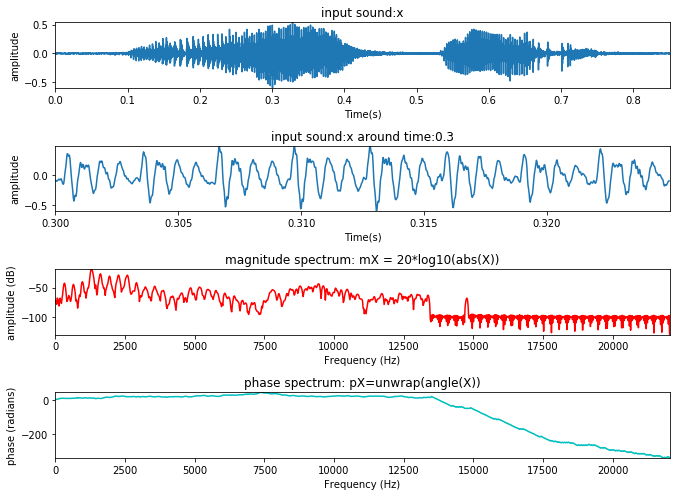

In [2]:
ipd.display(ipd.Audio(data=x,rate=fs))
t=np.arange(x.size)/float(fs)
time=0.3
pin = int(time*fs)
hM1 = int(m.floor((w.size+1)/2)) 
hM2 = int(m.floor(w.size/2))  
x1 = x[pin-hM1:pin+hM2]
mX, pX = DFT.dftAnal(x1, w, N)

plt.figure(1, figsize=(9.5, 7))

plt.subplot(4,1,1)
plt.plot(t, x, lw=1.5)
plt.axis([0,max(t),min(x),max(x)])
plt.xlabel('Time(s)')
plt.ylabel('amplitude')
plt.title('input sound:x')

plt.subplot(4,1,2)
plt.plot(time + np.arange(M)/float(fs), x1)
plt.axis([time, time + M/float(fs), min(x1), max(x1)])
plt.xlabel('Time(s)')
plt.ylabel('amplitude')
plt.title('input sound:x around time:0.3')


plt.subplot(4,1,3)
plt.plot(float(fs)*np.arange(mX.size)/float(N), mX, 'r', lw=1.5)
plt.axis([0, fs/2.0, min(mX), max(mX)])
plt.title ('magnitude spectrum: mX = 20*log10(abs(X))')
plt.ylabel('amplitude (dB)')
plt.xlabel('Frequency (Hz)')

plt.subplot(4,1,4)
plt.plot(float(fs)*np.arange(pX.size)/float(N), pX, 'c')
plt.axis([0, fs/2.0, min(pX), max(pX)])
plt.title ('phase spectrum: pX=unwrap(angle(X))')
plt.ylabel('phase (radians)')
plt.xlabel('Frequency (Hz)')

plt.tight_layout()


(0, 0.8463492063492063)

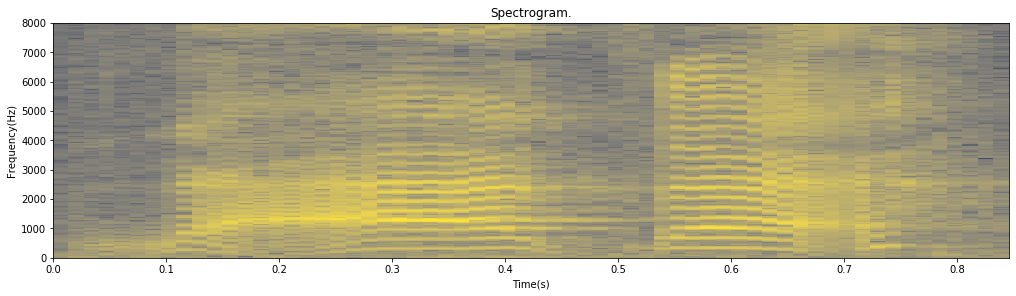

In [3]:
mX,pX= stft.stftAnal(x,w,N,H)

figure,axs = plt.subplots(figsize = (14,4), constrained_layout = True)

numFrames = int(mX[:,0].size)
frmTime = H*np.arange(numFrames)/float(fs)                             
binFreq = np.arange(N/2+1)*float(fs)/N                         
axs.pcolormesh(frmTime, binFreq, np.transpose(mX),cmap='cividis')
axs.set_title('Spectrogram.')
plt.autoscale(tight=True)
axs.set_xlabel('Time(s)')
axs.set_ylabel('Frequency(Hz)')
axs.set_ylim(0,8000)
axs.set_xlim(0,max(frmTime))

**DESCRIPTION OF THE SOUND**


**Part 2 (option c): Sound classification**

The aim of this exercise is to extend what you did in Assignment 9 on the topic of automatic sound
classification. The goal is to perform a classification of your sound within 3 sound classes that you define,
extracting and using low-level Essentia descriptors and a k-NN classifier. The sound classes should be
collections of sounds from freesound, but you should not attach the sound collections, your code should
load the sounds directly from freesound.

1. Analyze with Essentia your sound, selecting a maximum of 10 descriptors from the ones used in
the free-sound extractor, that you believe are most adequate. Use only the statistical aggregations
of each descriptor. Display the analysis data and explain your choices and your results.

2. Create 3 sound collections manually, using sounds from freesound that you believe can
exemplify your classification task. Each collection should be a list of the freesound urls, thus
sounds should not be downloaded and edited. Your code should access directly the sounds using
the freesound api. Each collection should not be larger than 10 sounds each. No collection
should include any sound that is “very” similar to your sound and each collection should have a
coherence. You can use, and explain, your own definition of similarity and coherence. Analyze
the 3 sound collections with the descriptors chosen in question 1. Display the analysis data and
explain your choices and your results.

3. Perform a classification of your sound using a k-NN classifier, choosing your own k value.
Display the result and explain the classification obtained.

**INTRODUCTION OF THE SECOND PART**

For this part, since I had to perform a classification and the sound I had to describe was the sound of a baby, it occurred to me that it would be helpful to have an efficient classifier between the sounds of a baby crying and a baby babbling. This classification could have pragmatic applications, for example as an alert system for a baby's room. 

In that line I searched for literature about the features that are taken into account for this kind of classification and found that what is mostly used are the mel frequency cepstrum coefficients.

Citing the paper [1]: *A baby cry sound is generated by an excitation of the vocal cords producing a sequence of periodic impulses. In healthy babies the fundamental frequency (F0) reaches values between 250Hz - 600Hz, which has a higher range than that of adult females and males. Hence, a higher F0 characterizes most of the baby cry sounds, as depicted in Fig. 1. Given these spectral properties, MFCCs have been proven in the literature to be a good candidate for baby cry detection task since it representseach signal as rate of change in the frequency bands. Due to baby cry harmonics, MFCCs represent this information with higher MFCCs coefficients.*

And in paper [2]: *A voice input must be ascertained as infant's cry sound which using 3 features extraction (pitch with 2 approaches: Modified Autocorrelation Function and Cepstrum Pitch Determination, Energy, and Harmonic Ratio)*

Therefore the descriptors I choose are in order to be able to do this classification better. (MFCC,pitch,inharmonicity...) 

Since I need to add a third class I thought that a sneeze sound could also be interesting. Based on the characteristics of this sound I included descriptors such as the attack time, and some rythm descriptors (since a crying sound has a more clear rythm).


!!! Important for part 2: I had to create two folders in the workspace called: **testDownload_exam** and **testKnn_exam**. Please note that to obtain the same results two sounds have to be removed manually before the clustering and classifications procedures. (it is explained before downloading such sounds).

[1]: Torres, R., Battaglino, D., & Lepauloux, L. (2017, August). Baby cry sound detection: A comparison of hand crafted features and deep learning approach. In International Conference on Engineering Applications of Neural Networks (pp. 168-179). Springer, Cham.

[2]: Rosita, Y. D., & Junaedi, H. (2016, October). Infant's cry sound classification using Mel-Frequency Cepstrum Coefficients feature extraction and Backpropagation Neural Network. In 2016 2nd International Conference on Science and Technology-Computer (ICST) (pp. 160-166). IEEE.

In [115]:
#Importing libraries and using functions from E9:

import os, sys
import json
sys.path.append('../../freesound-python-master')  # directory were you installed the freesound-python repository
import freesound as fs
from matplotlib.lines import Line2D
from scipy.cluster.vq import vq, kmeans, whiten

# Mapping of descriptors
descriptorMapping = { 0: 'sfx.logattacktime.mean',
                      1: 'lowlevel.mfcc.mean.0',
                      2: 'lowlevel.mfcc.mean.1',
                      3: 'lowlevel.mfcc.mean.2',
                      4: 'lowlevel.mfcc.mean.3',
                      5: 'lowlevel.mfcc.mean.4',
                      6: 'lowlevel.mfcc.mean.5',
                      7: 'lowlevel.mfcc.mean.6',
                      8: 'lowlevel.mfcc.mean.7',
                      9: 'lowlevel.mfcc.mean.8',
                      10: 'lowlevel.mfcc.mean.9',
                      11: 'lowlevel.mfcc.mean.10',
                      12: 'lowlevel.mfcc.mean.11',
                      13: 'lowlevel.mfcc.mean.12',
                      14: 'sfx.inharmonicity.mean',
                      15: 'rhythm.beats_count',
                      16: 'rhythm.bpm',
                      17: 'rhythm.onset_count',
                      18:'lowlevel.pitch.mean'}


descriptors = ['sfx.logattacktime.mean',
                'lowlevel.mfcc.mean',
                'sfx.inharmonicity.mean',
                'rhythm.beats_count',
                'rhythm.bpm',
                'rhythm.onset_count',
                 'lowlevel.pitch.mean']

def download_sounds_freesound(queryText = "", tag=None, duration=None, API_Key = "", outputDir = "", topNResults = 5, featureExt = '.json'):
      """
      This function downloads sounds and their descriptors from freesound using the queryText and the 
      tag specified in the input. Additionally, you can also specify the duration range to filter sounds 
      based on duration.

      Inputs:
            (Input parameters marked with a * are optional)
            queryText (string): query text for the sounds (eg. "violin", "trumpet", "cello", "bassoon" etc.)
            tag* (string): tag to be used for filtering the searched sounds. (eg. "multisample",  
                           "single-note" etc.)
            duration* (tuple): min and the max duration (seconds) of the sound to filter, eg. (0.2,15)
            API_Key (string): your api key, which you can obtain from : www.freesound.org/apiv2/apply/
            outputDir (string): path to the directory where you want to store the sounds and their 
                                descriptors
            topNResults (integer): number of results(sounds) that you want to download 
            featureExt (string): file extension for storing sound descriptors
      output:
            This function downloads sounds and descriptors, and then stores them in outputDir. In 
            outputDir it creates a directory of the same name as that of the queryText. In this 
            directory outputDir/queryText it creates a directory for every sound with the name 
            of the directory as the sound id. Additionally, this function also dumps a text file 
            containing sound-ids and freesound links for all the downloaded sounds in the outputDir. 
            NOTE: If the directory outputDir/queryText exists, it deletes the existing contents 
            and stores only the sounds from the current query. 
      """ 

      # Checking for the compulsory input parameters
      if queryText == "":
        print("\n")
        print("Provide a query text to search for sounds")
        return -1

      if API_Key == "":
        print("\n")
        print("You need a valid freesound API key to be able to download sounds.")
        print("Please apply for one here: www.freesound.org/apiv2/apply/")
        print("\n")
        return -1

      if outputDir == "" or not os.path.exists(outputDir):
        print("\n")
        print("Please provide a valid output directory. This will be the root directory for storing sounds and descriptors")
        return -1    

      # Setting up the Freesound client and the authentication key
      fsClnt = fs.FreesoundClient()
      fsClnt.set_token(API_Key,"token")  

      # Creating a duration filter string that the Freesound API understands
      if duration and type(duration) == tuple:
        flt_dur = " duration:[" + str(duration[0])+ " TO " +str(duration[1]) + "]"
      else:
        flt_dur = ""

      if tag and type(tag) == str:
        flt_tag = "tag:"+tag
      else:
        flt_tag = ""

      # Querying Freesound
      page_size = 30
      if not flt_tag + flt_dur == "":
        qRes = fsClnt.text_search(query=queryText ,filter = flt_tag + flt_dur,sort="score", fields="id,name,previews,username,url,analysis", descriptors=','.join(descriptors), page_size=page_size, normalized=1)
      else:
        qRes = fsClnt.text_search(query=queryText ,sort="score",fields="id,name,previews,username,url,analysis", descriptors=','.join(descriptors), page_size=page_size, normalized=1)

      outDir2 = os.path.join(outputDir, queryText)
      if os.path.exists(outDir2):             # If the directory exists, it deletes it and starts fresh
          os.system("rm -r " + outDir2)
      os.mkdir(outDir2)

      pageNo = 1
      sndCnt = 0
      indCnt = 0
      totalSnds = min(qRes.count,200)   # System quits after trying to download after 200 times

      # Creating directories to store output and downloading sounds and their descriptors
      downloadedSounds = []
      while(1):
        if indCnt >= totalSnds:
          print("Not able to download required number of sounds. Either there are not enough search results on freesound for your search query and filtering constraints or something is wrong with this script.")
          break
        sound = qRes[indCnt - ((pageNo-1)*page_size)]
        print("Downloading mp3 preview and descriptors for sound with id: %s"%str(sound.id))
        outDir1 = os.path.join(outputDir, queryText, str(sound.id))
        if os.path.exists(outDir1):
          os.system("rm -r " + outDir1)
        os.system("mkdir " + outDir1)

        mp3Path = os.path.join(outDir1,  str(sound.previews.preview_lq_mp3.split("/")[-1]))
        ftrPath = mp3Path.replace('.mp3', featureExt)

        try:

          fs.FSRequest.retrieve(sound.previews.preview_lq_mp3, fsClnt, mp3Path)
          # Initialize a dictionary to store descriptors
          features = {}
          # Obtaining all the descriptors
          for desc in descriptors:
            features[desc]=[]
            features[desc].append(eval("sound.analysis."+desc))

          # Once we have all the descriptors, store them in a json file
          json.dump(features, open(ftrPath,'w'))
          sndCnt+=1
          downloadedSounds.append([str(sound.id), sound.url])

        except:
          if os.path.exists(outDir1):
            os.system("rm -r " + outDir1)

        indCnt +=1

        if indCnt%page_size==0:
          qRes = qRes.next_page()
          pageNo+=1

        if sndCnt>=topNResults:
            break

      # Dump the list of files and Freesound links
      fid = open(os.path.join(outDir2, queryText+'_SoundList.txt'), 'w')
      for elem in downloadedSounds:
        fid.write('\t'.join(elem)+'\n')
      fid.close()
    
def convFtrDict2List(ftrDict):
  """
  This function converts descriptor dictionary to an np.array. The order in the numpy array (indices) 
  are same as those mentioned in descriptorMapping dictionary.
  
  Input: 
    ftrDict (dict): dictionary containing descriptors downloaded from the freesound
  Output: 
    ftr (np.ndarray): Numpy array containing the descriptors for processing later on
  """
  ftr = []
  for key in range(len(descriptorMapping.keys())):
    try:
      ftrName, ind = '.'.join(descriptorMapping[key].split('.')[:-1]), int(descriptorMapping[key].split('.')[-1])
      ftr.append(ftrDict[ftrName][0][ind])
    except:
      ftr.append(ftrDict[descriptorMapping[key]][0])
  return np.array(ftr)

def fetchDataDetails(inputDir, descExt = '.json'):
  """
  This function is used by other functions to obtain the information regarding the directory structure 
  and the location of descriptor files for each sound 
  """
  dataDetails = {}
  for path, dname, fnames  in os.walk(inputDir):
    for fname in fnames:
      if descExt in fname.lower():
        remain, rname, cname, sname = path.split('\\')[:-3], path.split('\\')[-3], path.split('\\')[-2], path.split('\\')[-1]
        if cname not in dataDetails:
          dataDetails[cname]={}
        fDict = json.load(open(os.path.join('\\'.join(remain), rname, cname, sname, fname),'r'))
        dataDetails[cname][sname]={'file': fname, 'feature':fDict}
  return dataDetails

**ANALYSIS OF THE SOUND WITH ESSENTIA**

In the following part I analyse the sound with the descriptors I chose for the classification. I also compare it to a crying sound to asses the possible differences.


In [116]:
#Download the sound and descriptors
download_sounds_freesound(queryText='113310', API_Key= 'UE3ueYmTeiV40zkzo6ewtjvn2TD1kuQwHuRBfKIO', outputDir='testKnn_exam', topNResults=1)
download_sounds_freesound(queryText='cry', API_Key= 'UE3ueYmTeiV40zkzo6ewtjvn2TD1kuQwHuRBfKIO', outputDir='testKnn_exam', topNResults=1,tag="crying%20tag:baby")

Baby sound
attack time: [0.39131683111190796]
inharmonicity: [0.771598219871521]
beats count: [0.3654593229293823]
bpm: [0.21329408884048462]
onset count: [0.3935384154319763]
pitch: [0.46849608421325684]


Text(0, 0.5, 'magnitude of coefficients')

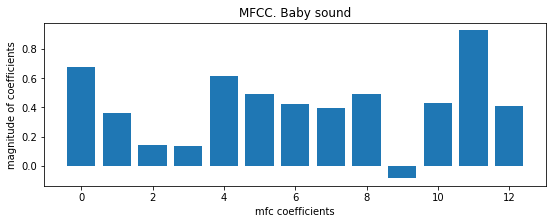

In [117]:
soundDir = os.path.normpath("testKnn_exam/")
dataDetails = fetchDataDetails(soundDir)


mfcc = dataDetails['113310']['113310']['feature']['lowlevel.mfcc.mean'][0]
bins = np.arange(13)

print('Baby sound')
print('attack time:', dataDetails['113310']['113310']['feature']['sfx.logattacktime.mean'])
print('inharmonicity:', dataDetails['113310']['113310']['feature']['sfx.inharmonicity.mean'])
print('beats count:', dataDetails['113310']['113310']['feature']['rhythm.beats_count'])
print('bpm:', dataDetails['113310']['113310']['feature']['rhythm.bpm'])
print('onset count:', dataDetails['113310']['113310']['feature']['rhythm.onset_count'])
print('pitch:', dataDetails['113310']['113310']['feature']['lowlevel.pitch.mean'])



fig, axs = plt.subplots(1, 1, figsize=(9, 3))
axs.set_title('MFCC. Baby sound')
axs.bar(bins,mfcc)
axs.set_xlabel('mfc coefficients')
axs.set_ylabel('magnitude of coefficients')

Crying sound
attack time: [0.762583315372467]
inharmonicity: [0.5173940658569336]
beats count: [0.5041696429252625]
bpm: [0.5726090669631958]
onset count: [0.5263418555259705]
pitch: [0.4413260817527771]


Text(0, 0.5, 'magnitude of coefficients')

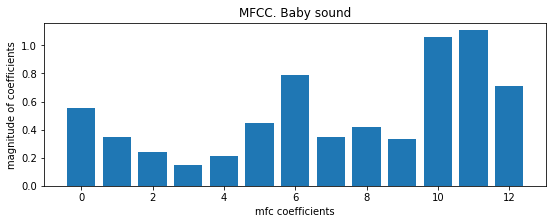

In [118]:

mfcc = dataDetails['cry']['211528']['feature']['lowlevel.mfcc.mean'][0]
bins = np.arange(13)

print('Crying sound')
print('attack time:', dataDetails['cry']['211528']['feature']['sfx.logattacktime.mean'])
print('inharmonicity:', dataDetails['cry']['211528']['feature']['sfx.inharmonicity.mean'])
print('beats count:', dataDetails['cry']['211528']['feature']['rhythm.beats_count'])
print('bpm:', dataDetails['cry']['211528']['feature']['rhythm.bpm'])
print('onset count:', dataDetails['cry']['211528']['feature']['rhythm.onset_count'])
print('pitch:', dataDetails['cry']['211528']['feature']['lowlevel.pitch.mean'])



fig, axs = plt.subplots(1, 1, figsize=(9, 3))
axs.set_title('MFCC. Baby sound')
axs.bar(bins,mfcc)
axs.set_xlabel('mfc coefficients')
axs.set_ylabel('magnitude of coefficients')

**EXPLANATION**

From this results we see that higher MFC coefficents are indeed higher in the crying sound, however this are only two examples and can't be yet generalized.
The crying sound also has a higher bpm, however, since we don't know how this algorithm is estimating the tempo, we can't be sure if it's going to be useful for the classification. 

The pitch is very similar in both sounds. Even if we don't check the pitch confidence the fact that both sounds got a similar one means it is accurate. The pitch of a baby voice is similar to the crying one.

**CREATING SOUND COLLECTIONS**

**I download the searches but for the "cry" collection I manually delete two sounds that are a lighter cry (71193,17933) and could be understood as 'baby', which we understand as babbling**

In [119]:
download_sounds_freesound(queryText='baby', API_Key= 'UE3ueYmTeiV40zkzo6ewtjvn2TD1kuQwHuRBfKIO', outputDir='testDownload_exam', topNResults = 10, duration=(0,3), tag="babbling%20tag:noisecollector")
download_sounds_freesound(queryText='cry', API_Key= 'UE3ueYmTeiV40zkzo6ewtjvn2TD1kuQwHuRBfKIO', outputDir='testDownload_exam', topNResults = 12,  duration=(0,10),  tag="crying%20tag:baby")
download_sounds_freesound(queryText='sneeze', API_Key= 'UE3ueYmTeiV40zkzo6ewtjvn2TD1kuQwHuRBfKIO', outputDir='testDownload_exam', topNResults = 10,  duration=(0,5))

**PERFORM PREVIOUS CLUSTERING TO ASSESS DESCRIPTORS**

In this section I decided to perform an initial clustering and asses the quality of the descriptors. I end up choosing the descriptors:

- 0. Attack time

- 1. mfcc 0

- 3. mfcc 2

- 12. mfcc 11

- 14. inharmonicity (is helpful to separate sneeze from cry)

I present two of this clustering examples:  for 1,3 the clusters are separated diagonally and for 0,14 only cry and sneeze are more separated. The descriptor 12 is not very clearly helpful but it does help with the density of the clusters and raises accuracy in the next k-means method.

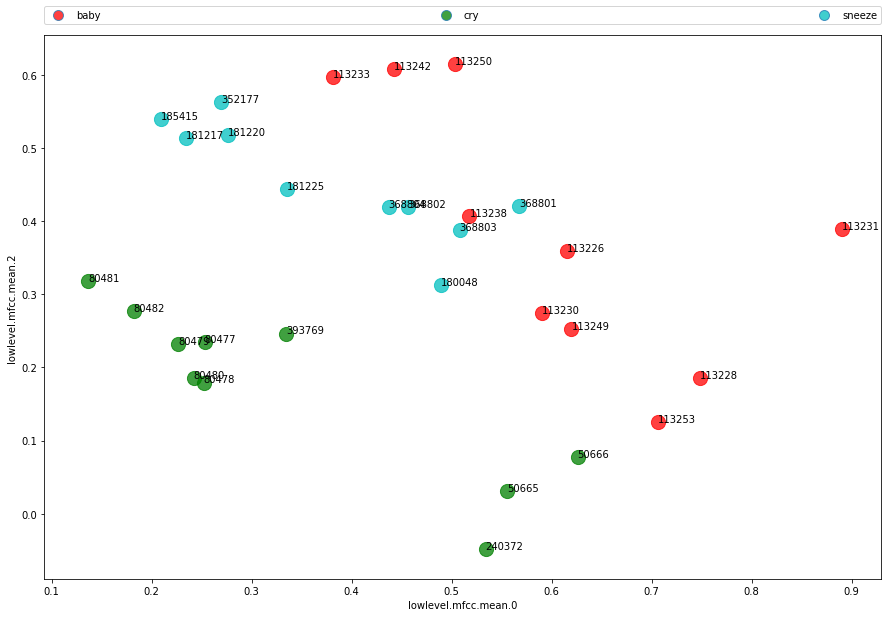

In [177]:
inputDir = os.path.normpath("testDownload_exam/")

### Selecting the descriptors for the clustering

descInput = (1,3)

anotOn = 1
dataDetails = fetchDataDetails(inputDir)
colors = ['r', 'g', 'c', 'b', 'k', 'm', 'y']

plt.figure(figsize=(15, 10))

legArray = []
catArray = []
for ii, category in enumerate(dataDetails.keys()):
    catArray.append(category)
    for soundId in dataDetails[category].keys():
        filepath = os.path.join(inputDir, category, soundId, dataDetails[category][soundId]['file'])
        descSound = convFtrDict2List(json.load(open(filepath, 'r')))
        x_cord = descSound[descInput[0]]
        y_cord = descSound[descInput[1]]
        plt.scatter(x_cord, y_cord, c = colors[ii], s=200, alpha=0.75)
        if anotOn==1:
            plt.annotate(soundId, xy=(x_cord, y_cord), xytext=(x_cord, y_cord))
    circ = Line2D([0], [0], linestyle="none", marker="o", alpha=0.75, markersize=10, markerfacecolor=colors[ii])
    legArray.append(circ)
  
plt.ylabel(descriptorMapping[descInput[1]])
plt.xlabel(descriptorMapping[descInput[0]])
plt.legend(legArray,catArray,numpoints=1,bbox_to_anchor=(0.,1.02,1.,.102),loc=3,ncol=len(catArray),mode="expand",borderaxespad=0.)


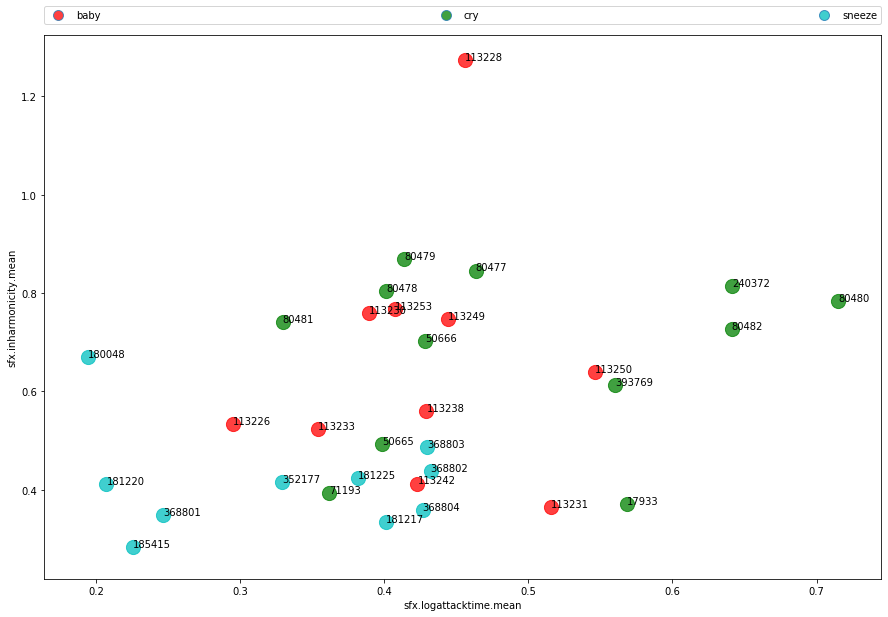

In [121]:
inputDir = os.path.normpath("testDownload_exam/")

### Selecting the descriptors

descInput = (0,14)

anotOn = 1
dataDetails = fetchDataDetails(inputDir)
colors = ['r', 'g', 'c', 'b', 'k', 'm', 'y']

plt.figure(figsize=(15, 10))

legArray = []
catArray = []
for ii, category in enumerate(dataDetails.keys()):
    catArray.append(category)
    for soundId in dataDetails[category].keys():
        filepath = os.path.join(inputDir, category, soundId, dataDetails[category][soundId]['file'])
        descSound = convFtrDict2List(json.load(open(filepath, 'r')))
        x_cord = descSound[descInput[0]]
        y_cord = descSound[descInput[1]]
        plt.scatter(x_cord, y_cord, c = colors[ii], s=200, alpha=0.75)
        if anotOn==1:
            plt.annotate(soundId, xy=(x_cord, y_cord), xytext=(x_cord, y_cord))
    circ = Line2D([0], [0], linestyle="none", marker="o", alpha=0.75, markersize=10, markerfacecolor=colors[ii])
    legArray.append(circ)
  
plt.ylabel(descriptorMapping[descInput[1]])
plt.xlabel(descriptorMapping[descInput[0]])
plt.legend(legArray,catArray,numpoints=1,bbox_to_anchor=(0.,1.02,1.,.102),loc=3,ncol=len(catArray),mode="expand",borderaxespad=0.)


**CLASSIFICATION WITH K-MEANS**

I wanted to add this part to prove that a classification with only two classes (cry and baby) would be more effective than adding the class 'sneeze'.  We can see that:

- First classification: classes 'cry', 'baby' (babbling) and 'sneeze'. With the descriptors chosen above we obtain an accuracy of around 75%. Most of the missclassified sounds are the ones that belong to 'sneeze'.

-  Second classification: We set only two clusters and we find that classes 'cry' and 'baby' (babbling) are well classified, while 'sneeze' is the one that gets mixed classification. Note that here we don't use the inharmonicity descriptor (we used it only because it helped recognizing the 'sneeze' class.  Also note that the accuracy is not relevant in this case because the labeling doesn't correspond to the number of clusters. 

With this results we can see that the objective of classificating between crying and other baby sounds can be reached with good results, especially with the use of the MFC coefficients as the literature said.

In [142]:
def cluster_sounds(targetDir, nCluster = -1, descInput=[]):
  """
  This function clusters all the sounds in targetDir using kmeans clustering.
  
  Input:
    targetDir (string): Directory where sound descriptors are stored (all the sounds in this 
                        directory will be used for clustering)
    nCluster (int): Number of clusters to be used for kmeans clustering.
    descInput (list) : List of indices of the descriptors to be used for similarity/distance 
                       computation (see descriptorMapping)
  Output:
    Prints the class of each cluster (computed by a majority vote), number of sounds in each 
    cluster and information (sound-id, sound-class and classification decision) of the sounds 
    in each cluster. Optionally, you can uncomment the return statement to return the same data.
  """
  
  dataDetails = fetchDataDetails(targetDir)
  
  ftrArr = []
  infoArr = []
  
  if nCluster ==-1:
    nCluster = len(dataDetails.keys())
  for cname in dataDetails.keys():
    #iterating over sounds
    for sname in dataDetails[cname].keys():
      ftrArr.append(convFtrDict2List(dataDetails[cname][sname]['feature'])[descInput])
      infoArr.append([sname, cname])
  
  ftrArr = np.array(ftrArr)
  infoArr = np.array(infoArr)
  
  ftrArrWhite = whiten(ftrArr)
  centroids, distortion = kmeans(ftrArrWhite, nCluster)
  clusResults = -1*np.ones(ftrArrWhite.shape[0])
  
  for ii in range(ftrArrWhite.shape[0]):
    diff = centroids - ftrArrWhite[ii,:]
    diff = np.sum(np.power(diff,2), axis = 1)
    indMin = np.argmin(diff)
    clusResults[ii] = indMin
  
  ClusterOut = []
  classCluster = []
  globalDecisions = []  
  for ii in range(nCluster):
    ind = np.where(clusResults==ii)[0]
    freqCnt = []
    for elem in infoArr[ind,1]:
      freqCnt.append(infoArr[ind,1].tolist().count(elem))
    indMax = np.argmax(freqCnt)
    classCluster.append(infoArr[ind,1][indMax])
    
    print("\n(Cluster: " + str(ii) + ") Using majority voting as a criterion this cluster belongs to " + 
          "class: " + classCluster[-1])
    print ("Number of sounds in this cluster are: " + str(len(ind)))
    decisions = []
    for jj in ind:
        if infoArr[jj,1] == classCluster[-1]:
            decisions.append(1)
        else:
            decisions.append(0)
    globalDecisions.extend(decisions)
    print ("sound-id, sound-class, classification decision")
    ClusterOut.append(np.hstack((infoArr[ind],np.array([decisions]).T)))
    print (ClusterOut[-1])
  globalDecisions = np.array(globalDecisions)
  totalSounds = len(globalDecisions)
  nIncorrectClassified = len(np.where(globalDecisions==0)[0])
  print("Out of %d sounds, %d sounds are incorrectly classified considering that one cluster should "
        "ideally contain sounds from only a single class"%(totalSounds, nIncorrectClassified))
  print("You obtain a classification (based on obtained clusters and majority voting) accuracy "
         "of %.2f percentage"%round(float(100.0*float(totalSounds-nIncorrectClassified)/totalSounds),2))
  # return ClusterOut

In [174]:
# FIRST CLASSIFICATION: 3 CLASSES

targetDir = os.path.normpath("testDownload_exam/")
nCluster=3
descInput= [0,1,3,14,12]
cluster_sounds(targetDir, nCluster, descInput)


(Cluster: 0) Using majority voting as a criterion this cluster belongs to class: sneeze
Number of sounds in this cluster are: 15
sound-id, sound-class, classification decision
[['113226' 'baby' '0']
 ['113233' 'baby' '0']
 ['113238' 'baby' '0']
 ['113242' 'baby' '0']
 ['113250' 'baby' '0']
 ['180048' 'sneeze' '1']
 ['181217' 'sneeze' '1']
 ['181220' 'sneeze' '1']
 ['181225' 'sneeze' '1']
 ['185415' 'sneeze' '1']
 ['352177' 'sneeze' '1']
 ['368801' 'sneeze' '1']
 ['368802' 'sneeze' '1']
 ['368803' 'sneeze' '1']
 ['368804' 'sneeze' '1']]

(Cluster: 1) Using majority voting as a criterion this cluster belongs to class: baby
Number of sounds in this cluster are: 6
sound-id, sound-class, classification decision
[['113228' 'baby' '1']
 ['113230' 'baby' '1']
 ['113231' 'baby' '1']
 ['113249' 'baby' '1']
 ['113253' 'baby' '1']
 ['50666' 'cry' '0']]

(Cluster: 2) Using majority voting as a criterion this cluster belongs to class: cry
Number of sounds in this cluster are: 9
sound-id, sound-clas

In [173]:
targetDir = os.path.normpath("testDownload_exam/")
nCluster=2
descInput= [1,3,0,12]
cluster_sounds(targetDir, nCluster, descInput)


(Cluster: 0) Using majority voting as a criterion this cluster belongs to class: cry
Number of sounds in this cluster are: 11
sound-id, sound-class, classification decision
[['240372' 'cry' '1']
 ['393769' 'cry' '1']
 ['50665' 'cry' '1']
 ['80477' 'cry' '1']
 ['80478' 'cry' '1']
 ['80479' 'cry' '1']
 ['80480' 'cry' '1']
 ['80481' 'cry' '1']
 ['80482' 'cry' '1']
 ['181217' 'sneeze' '0']
 ['181225' 'sneeze' '0']]

(Cluster: 1) Using majority voting as a criterion this cluster belongs to class: baby
Number of sounds in this cluster are: 19
sound-id, sound-class, classification decision
[['113226' 'baby' '1']
 ['113228' 'baby' '1']
 ['113230' 'baby' '1']
 ['113231' 'baby' '1']
 ['113233' 'baby' '1']
 ['113238' 'baby' '1']
 ['113242' 'baby' '1']
 ['113249' 'baby' '1']
 ['113250' 'baby' '1']
 ['113253' 'baby' '1']
 ['50666' 'cry' '0']
 ['180048' 'sneeze' '0']
 ['181220' 'sneeze' '0']
 ['185415' 'sneeze' '0']
 ['352177' 'sneeze' '0']
 ['368801' 'sneeze' '0']
 ['368802' 'sneeze' '0']
 ['36880

**K-NN CLASSIFICATION**

Here we get to our final test. We want to test if our initial sound, that was a baby babbling, is classified as that class or not. Note that this sound wasn't present in the 'baby' collection.

We see that it does get well classified for several values of k, which means that the descriptors chosen were good enough.
However, if we take into account the highest MFC coefficient our value gets missclassified, probably because it has higher frequencies than most babblings and therefore it is in the boundary.

In [149]:
def compute_similar_sounds(queryFile, targetDir, descInput = []):
  """
  This function returns similar sounds for a specific queryFile. Given a queryFile this function 
  computes the distance of the query to all the sounds found in the targetDir and sorts them in 
  the increasing order of the distance. This way we can obtain similar sounds to a query sound.
  
  Input:
    queryFile (string): Descriptor file (.json, unless changed)
    targetDir (string): Target directory to search for similar sounds (using their descriptor files)
    descInput (list) : list of indices of the descriptors to be used for similarity/distance computation 
                       (see descriptorMapping)
  Output: 
    List containing an ordered list of similar sounds. 
  """
  
  dataDetails = fetchDataDetails(targetDir)
  
  #reading query feature dictionary
  qFtr = json.load(open(queryFile, 'r'))
  dist = []
  # Iterating over classes
  for cname in dataDetails.keys():
    # Iterating over sounds
    for sname in dataDetails[cname].keys():
      f1 =  convFtrDict2List(qFtr)
      f2 =  convFtrDict2List(dataDetails[cname][sname]['feature'])
      eucDist = np.sqrt(np.sum(np.power(np.array(f1[descInput]) - np.array(f2[descInput]), 2)))
      dist.append([eucDist, sname, cname])
  
  # Sorting the array based on the distance
  indSort = np.argsort(np.array(dist)[:,0])
  return (np.array(dist)[indSort,:]).tolist()

        
def classify_sound_kNN(queryFile, targetDir, K, descInput = []):
  """
  This function performs the KNN classification of a sound. The nearest neighbors are chosen from 
  the sounds in the targetDir.
   
  Input:
    queryFile (string): Descriptor file (.json, unless changed)
    targetDir (string): Target directory to search for similar sounds (using their descriptor files)
    K (int) : Number of nearest neighbors to consider for KNN classification.
    descInput (list) : List of indices of the descriptors to be used for similarity/distance computation 
                      (see descriptorMapping)
  Output:
    predClass (string): Predicted class of the query sound
  """
  distances = compute_similar_sounds(queryFile, targetDir, descInput)
  if len(np.where((np.array(distances)[:,0].astype(np.float64))==0)[0])>0:
    print("Warning: We found an exact copy of the query file in the target directory. "
          "Beware of duplicates while doing KNN classification.")
  
  classes = (np.array(distances)[:K,2]).tolist()
  freqCnt = []
  for ii in range(K):
    freqCnt.append(classes.count(classes[ii]))
  indMax = np.argmax(freqCnt)
  predClass =  classes[indMax]
  print ("This sample belongs to class: " + str(predClass))
  return predClass

In [170]:
#classify the sound, k=1
queryFile = "testKnn_exam\\113310\\113310\\113310_4948-lq.json"
targetDir = os.path.normpath("testDownload_exam/")
descInput= [0,1,3,14]
K=1
classify_sound_kNN(queryFile, targetDir, K, descInput)

This sample belongs to class: baby


'baby'

In [169]:
#classify the sound, k=7
queryFile = "testKnn_exam\\113310\\113310\\113310_4948-lq.json"
targetDir = os.path.normpath("testDownload_exam/")
descInput= [0,1,3,14]
K=7
classify_sound_kNN(queryFile, targetDir, K, descInput)

This sample belongs to class: baby


'baby'

In [168]:
#classify the sound: ADDING descriptor 12, k=5
queryFile = "testKnn_exam\\113310\\113310\\113310_4948-lq.json"
targetDir = os.path.normpath("testDownload_exam/")
descInput= [0,1,3,14,12]
K=5
classify_sound_kNN(queryFile, targetDir, K, descInput)

This sample belongs to class: cry


'cry'

**SUGGESTION TO IMPROVE**

Use of Gaussian Mixture Models to do the clustering ( it would capture certain shapes and lead to less missclassification) or other machine learning models for the labelled classification. Instead of considering a sneeze we could consider the moods behind the sound the baby is making.